In [12]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("tracker_stubs/ball_detections.pkl", 'rb')as f:
    ball_positions = pickle.load(f)

In [6]:
ball_positions = [x.get(1,[]) for x in ball_positions]
#convert list to df
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

#interpolate missing vals
df_ball_positions = df_ball_positions.interpolate()
#not gonna interpolate positions at beginnig, thus dupe earliest detection to start of frame => back fill
df_ball_positions = df_ball_positions.bfill() #edge case when first frame doesnt have a detection

# #convert back to list
# ball_positions = [{1:x} for x in df_ball_positions.to_numpy().tolist()]


In [8]:
#calc center of ball
df_ball_positions['mid_y']=(df_ball_positions['y1']+df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean']=df_ball_positions['mid_y'].rolling(window=5,min_periods=1,center=False).mean()

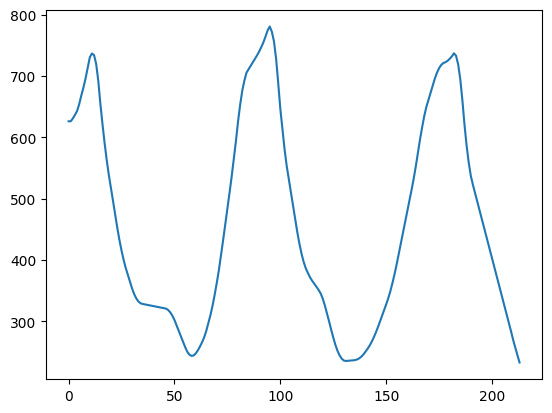

In [13]:
#plot ball pos
plt.plot(df_ball_positions['mid_y_rolling_mean'])

#whenever y pos changes, ball was hit

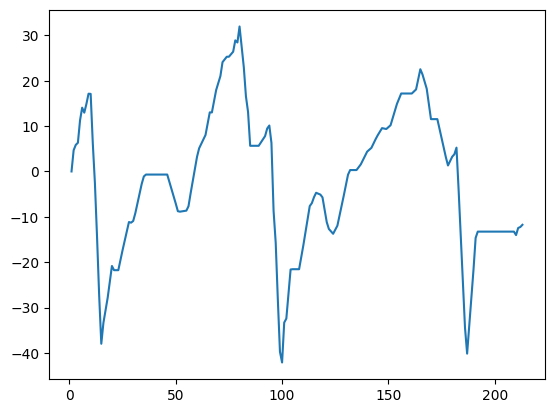

In [15]:
#figure out how much ball pos is changing
df_ball_positions['delta_y']= df_ball_positions['mid_y_rolling_mean'].diff()
plt.plot(df_ball_positions['delta_y'])


In [16]:
#to understand where ball was hit, loop over delta y and get frame num and pos when ball incs when decs and vice versa

df_ball_positions['ball_hit']=0

In [19]:
#calc center of ball
df_ball_positions['mid_y']=(df_ball_positions['y1']+df_ball_positions['y2'])/2
df_ball_positions['delta_y']= df_ball_positions['mid_y_rolling_mean'].diff()
df_ball_positions['mid_y_rolling_mean']=df_ball_positions['mid_y'].rolling(window=5,min_periods=1,center=False).mean()
min_change_frames_for_each_hit = 25
for i in range(1, len(df_ball_positions)- int(1.2*min_change_frames_for_each_hit)):
    neg_position_change = df_ball_positions['delta_y'].iloc[i]>0 and df_ball_positions['delta_y'].iloc[i+1]<0
    pos_position_change = df_ball_positions['delta_y'].iloc[i]<0 and df_ball_positions['delta_y'].iloc[i+1]>0
    
    if neg_position_change or pos_position_change:
        change_count=0
        for change_frame in range(i+1, i+int(min_change_frames_for_each_hit*1.2)+1):
            neg_position_change_next_frame = df_ball_positions['delta_y'].iloc[i]>0 and df_ball_positions['delta_y'].iloc[change_frame]<0
            pos_position_change_next_frame = df_ball_positions['delta_y'].iloc[i]<0 and df_ball_positions['delta_y'].iloc[change_frame]>0
            
            if neg_position_change and neg_position_change_next_frame:
                change_count+=1
            elif pos_position_change and pos_position_change_next_frame:
                change_count +=1
                
        if change_count > min_change_frames_for_each_hit-1:
            df_ball_positions['ball_hit'].iloc[i]=1
            
frame_nums_with_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

/var/folders/5m/2h4c_6kx02n46xq4zznnj2l00000gn/T/ipykernel_4423/4129608475.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i]=1
/var/folders/5m/2h4c_6kx02n46xq4zznnj2l00000gn/T/ipykernel_4423/412960847

In [22]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,778.540466,718.178833,796.772644,737.312439,727.745636,736.725934,6.248254,1
58,925.921936,240.836371,938.995300,253.911163,247.373767,243.610631,-2.135428,1
95,616.860229,771.535461,639.228027,799.617798,785.576630,780.777600,6.277484,1
131,717.904724,229.963753,729.199402,241.855240,235.909496,235.290754,-0.706718,1
182,1295.773438,740.696228,1312.837036,758.377258,749.536743,737.099405,5.252496,1
